In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
np.random.seed(12211)  
import time
from scipy.stats import norm

%matplotlib inline

In [2]:
plt.rc('font', size=18)
plt.rc('font', family="serif")
plt.rc('text', usetex=True)

In [3]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS']

n_epochs = 2000 #20
D = 5 
K = 3
learning_rate = 1e-5
decay_rate= 1e-3 
batch_size = 1024 
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [4]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [5]:
zgrid = np.arange(0.0,1.0,0.01)

def gaussian_vect(zgrid, mu, sigma, weight):
    exp = np.exp(-0.5 * np.add.outer(zgrid, -mu)**2/sigma**2)
    return weight / (sigma * np.sqrt(2*np.pi)) * exp

def realization_pz(X_test_orig, X_test_orig_errors):
    t0 = time.time()
    X_test_realization = np.random.normal(X_test_orig, X_test_orig_errors)

    t1 = time.time()
    ## Prediction 
    X_test_realization = preproc.transform(X_test_realization)
    y_pred = np.array(model_train(X_test_realization))
    t2 = time.time()
    
    weight = y_pred[2]
    weight = np.where(weight<1e-2, 0, weight)
    mu = y_pred[0]
    sig = np.sqrt(np.log(y_pred[1]))

    mu = preproc_y.inverse_transform(mu)
    sig = preproc_y.inverse_transform(sig)

    sig = np.clip(sig,0.001, np.inf)
    
    zipped = zip(mu.T, 
             sig.T, 
             weight.T)
    
    pz = np.sum([gaussian_vect(zgrid, m,s,w) for (m,s,w) in zipped], axis=0).T
    sum_pz = np.sum(pz,axis=1)[:,None]
    sum_pz[sum_pz==0] = 1.
    pz /= sum_pz
    t3 = time.time()
    print(t1-t0)
    print(t2-t0)
    print(t3-t0)
    #print(t1-t0)
    return pz

In [6]:
def minmax_cutsOBSarr(X, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    return X_new, y_new, l_new, mask_cond

In [7]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [8]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [9]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188479   -3.8901405  -2.1034117 -15.92296    12.114799 ]
ColMag-max:  [17.02884   7.925968  4.182415  2.264679 25.709858]
----------


In [10]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)
X_err = X_err[mask_cond]
X_test_orig = X_test.copy()
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2741, 5)
Size of output in test data: (2741,)


In [11]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

In [12]:
## Prediction 
X_test = preproc.transform(X_test)
y_pred = np.array(model_train(X_test))

weight = y_pred[2]
weight = np.where(weight<1e-2, 0, weight)
mu = y_pred[0]
sig = np.sqrt(np.log(y_pred[1]))

mu = preproc_y.inverse_transform(mu)
sig = preproc_y.inverse_transform(sig)

sig = np.clip(sig,0.001, np.inf)

zipped = zip(mu.T, 
         sig.T, 
         weight.T)

pz = np.sum([gaussian_vect(zgrid, m,s,w) for (m,s,w) in zipped], axis=0).T
pz /= np.sum(pz,axis=1)[:,None]

/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


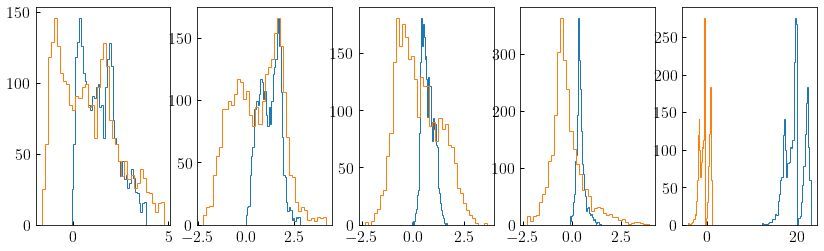

In [13]:
fig, ax = plt.subplots(1,5,figsize=(14,4))
for i in range(5):
    ax[i].hist(X_test_orig[:,i], 40, histtype='step')
    ax[i].hist(X_test[:,i], 40, histtype='step')
plt.show()

In [14]:
np.log(10)

2.302585092994046

In [15]:
## Best prediction (mean and std) of the Gaussian mixture is taken as the the one with highest weight
y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))

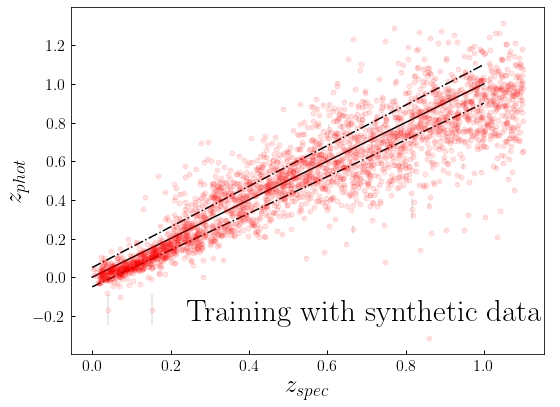

In [16]:
## Plotting mean and std-dev of predictions. The bias in prediction is clearly seen (esp at low-z)
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std

plt.figure(figsize=(8,6))

plt.errorbar(y_test, preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0], 
             yerr= preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0], 
             fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

C = 0.05
z_t = np.array([0, 1])
z_tp = z_t + C*(1+z_t)
z_tm = z_t - C*(1+z_t)
plt.plot(z_t, z_t, 'k')
plt.plot(z_t, z_tp, 'k-.')
plt.plot(z_t, z_tm, 'k-.')
plt.ylabel(r'$z_{phot}$', fontsize=25)
plt.xlabel(r'$z_{spec}$', fontsize=25)
plt.tight_layout()
#plt.axes().set_aspect('equal')
leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

(array([269., 297., 266., 239., 255., 255., 203., 100.,  26.,  12.]),
 array([0.00194505, 0.10795501, 0.21396497, 0.31997493, 0.4259849 ,
        0.5319948 , 0.6380048 , 0.74401474, 0.8500247 , 0.95603466,
        1.0620446 ], dtype=float32),
 <BarContainer object of 10 artists>)

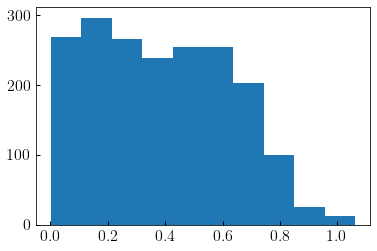

In [30]:
plt.hist(y_test[(label_test==0)])

In [17]:
import pzerrors

In [ ]:
Nintegral = 1000
#zgrid = np.arange(0.0,1.0,0.01)

sel = (label_test==0)&(y_test>0.2)&(y_test<0.8)
sel = np.arange(len(X_test_orig))[sel][np.random.choice(sel.sum(), 50, replace=False)]


features_test, features_error_test = X_test_orig[sel], X_err[sel]


pz_mag = pzerrors.pz_error_batch_magnitude(
    preproc, 
    preproc_y, 
    model_train, 
    features_test, 
    features_error_test,
    Nintegral,
    zgrid,
)
pz_flux = pzerrors.pz_error_batch_flux(
    preproc, 
    preproc_y, 
    model_train, 
    features_test, 
    features_error_test,
    Nintegral,
    zgrid,
)

pz_flux_QMC = pzerrors.pz_error_batch_flux_QMC(
    preproc, 
    preproc_y, 
    model_train, 
    features_test, 
    features_error_test,
    Nintegral,
    zgrid,
)



0 out of 1000
1 out of 1000
2 out of 1000
3 out of 1000
4 out of 1000
5 out of 1000
6 out of 1000
7 out of 1000
8 out of 1000
9 out of 1000
10 out of 1000
11 out of 1000
12 out of 1000
13 out of 1000
14 out of 1000
15 out of 1000
16 out of 1000
17 out of 1000
18 out of 1000
19 out of 1000
20 out of 1000
21 out of 1000
22 out of 1000
23 out of 1000
24 out of 1000
25 out of 1000
26 out of 1000
27 out of 1000
28 out of 1000
29 out of 1000
30 out of 1000
31 out of 1000
32 out of 1000
33 out of 1000
34 out of 1000
35 out of 1000
36 out of 1000
37 out of 1000
38 out of 1000
39 out of 1000
40 out of 1000
41 out of 1000
42 out of 1000
43 out of 1000
44 out of 1000
45 out of 1000
46 out of 1000
47 out of 1000
48 out of 1000
49 out of 1000
50 out of 1000
51 out of 1000
52 out of 1000
53 out of 1000
54 out of 1000
55 out of 1000
56 out of 1000
57 out of 1000
58 out of 1000
59 out of 1000
60 out of 1000
61 out of 1000
62 out of 1000
63 out of 1000
64 out of 1000
65 out of 1000
66 out of 1000
67 ou

523 out of 1000
524 out of 1000
525 out of 1000
526 out of 1000
527 out of 1000
528 out of 1000
529 out of 1000
530 out of 1000
531 out of 1000
532 out of 1000
533 out of 1000
534 out of 1000
535 out of 1000
536 out of 1000
537 out of 1000
538 out of 1000
539 out of 1000
540 out of 1000
541 out of 1000
542 out of 1000
543 out of 1000
544 out of 1000
545 out of 1000
546 out of 1000
547 out of 1000
548 out of 1000
549 out of 1000
550 out of 1000
551 out of 1000
552 out of 1000
553 out of 1000
554 out of 1000
555 out of 1000
556 out of 1000
557 out of 1000
558 out of 1000
559 out of 1000
560 out of 1000
561 out of 1000
562 out of 1000
563 out of 1000
564 out of 1000
565 out of 1000
566 out of 1000
567 out of 1000
568 out of 1000
569 out of 1000
570 out of 1000
571 out of 1000
572 out of 1000
573 out of 1000
574 out of 1000
575 out of 1000
576 out of 1000
577 out of 1000
578 out of 1000
579 out of 1000
580 out of 1000
581 out of 1000
582 out of 1000
583 out of 1000
584 out of 1000
585 out 

40 out of 1000
41 out of 1000
42 out of 1000
43 out of 1000
44 out of 1000
45 out of 1000
46 out of 1000
47 out of 1000
48 out of 1000
49 out of 1000
50 out of 1000
51 out of 1000
52 out of 1000
53 out of 1000
54 out of 1000
55 out of 1000
56 out of 1000
57 out of 1000
58 out of 1000
59 out of 1000
60 out of 1000
61 out of 1000
62 out of 1000
63 out of 1000
64 out of 1000
65 out of 1000
66 out of 1000
67 out of 1000
68 out of 1000
69 out of 1000
70 out of 1000
71 out of 1000
72 out of 1000
73 out of 1000
74 out of 1000
75 out of 1000
76 out of 1000
77 out of 1000
78 out of 1000
79 out of 1000
80 out of 1000
81 out of 1000
82 out of 1000
83 out of 1000
84 out of 1000
85 out of 1000
86 out of 1000
87 out of 1000
88 out of 1000
89 out of 1000
90 out of 1000
91 out of 1000
92 out of 1000
93 out of 1000
94 out of 1000
95 out of 1000
96 out of 1000
97 out of 1000
98 out of 1000
99 out of 1000
100 out of 1000
101 out of 1000
102 out of 1000
103 out of 1000
104 out of 1000
105 out of 1000
106 

558 out of 1000
559 out of 1000
560 out of 1000
561 out of 1000
562 out of 1000
563 out of 1000
564 out of 1000
565 out of 1000
566 out of 1000
567 out of 1000
568 out of 1000
569 out of 1000
570 out of 1000
571 out of 1000
572 out of 1000
573 out of 1000
574 out of 1000
575 out of 1000
576 out of 1000
577 out of 1000
578 out of 1000
579 out of 1000
580 out of 1000
581 out of 1000
582 out of 1000
583 out of 1000
584 out of 1000
585 out of 1000
586 out of 1000
587 out of 1000
588 out of 1000
589 out of 1000
590 out of 1000
591 out of 1000
592 out of 1000
593 out of 1000
594 out of 1000
595 out of 1000
596 out of 1000
597 out of 1000
598 out of 1000
599 out of 1000
600 out of 1000
601 out of 1000
602 out of 1000
603 out of 1000
604 out of 1000
605 out of 1000
606 out of 1000
607 out of 1000
608 out of 1000
609 out of 1000
610 out of 1000
611 out of 1000
612 out of 1000
613 out of 1000
614 out of 1000
615 out of 1000
616 out of 1000
617 out of 1000
618 out of 1000
619 out of 1000
620 out 

76 out of 1000
77 out of 1000
78 out of 1000
79 out of 1000
80 out of 1000
81 out of 1000
82 out of 1000
83 out of 1000
84 out of 1000
85 out of 1000
86 out of 1000
87 out of 1000
88 out of 1000
89 out of 1000
90 out of 1000
91 out of 1000
92 out of 1000
93 out of 1000
94 out of 1000
95 out of 1000
96 out of 1000
97 out of 1000
98 out of 1000
99 out of 1000
100 out of 1000
101 out of 1000
102 out of 1000
103 out of 1000
104 out of 1000
105 out of 1000
106 out of 1000
107 out of 1000
108 out of 1000
109 out of 1000
110 out of 1000
111 out of 1000
112 out of 1000
113 out of 1000
114 out of 1000
115 out of 1000
116 out of 1000
117 out of 1000
118 out of 1000
119 out of 1000
120 out of 1000
121 out of 1000
122 out of 1000
123 out of 1000
124 out of 1000
125 out of 1000
126 out of 1000
127 out of 1000
128 out of 1000
129 out of 1000
130 out of 1000
131 out of 1000
132 out of 1000
133 out of 1000
134 out of 1000
135 out of 1000
136 out of 1000
137 out of 1000
138 out of 1000
139 out of 1000


592 out of 1000
593 out of 1000
594 out of 1000
595 out of 1000
596 out of 1000
597 out of 1000
598 out of 1000
599 out of 1000
600 out of 1000
601 out of 1000
602 out of 1000
603 out of 1000
604 out of 1000
605 out of 1000
606 out of 1000
607 out of 1000
608 out of 1000
609 out of 1000
610 out of 1000
611 out of 1000
612 out of 1000
613 out of 1000
614 out of 1000
615 out of 1000
616 out of 1000
617 out of 1000
618 out of 1000
619 out of 1000
620 out of 1000
621 out of 1000
622 out of 1000
623 out of 1000
624 out of 1000
625 out of 1000
626 out of 1000
627 out of 1000
628 out of 1000
629 out of 1000
630 out of 1000
631 out of 1000
632 out of 1000
633 out of 1000
634 out of 1000
635 out of 1000
636 out of 1000
637 out of 1000
638 out of 1000
639 out of 1000
640 out of 1000
641 out of 1000
642 out of 1000
643 out of 1000
644 out of 1000
645 out of 1000
646 out of 1000
647 out of 1000
648 out of 1000
649 out of 1000
650 out of 1000
651 out of 1000
652 out of 1000
653 out of 1000
654 out 

0.15848931924611134

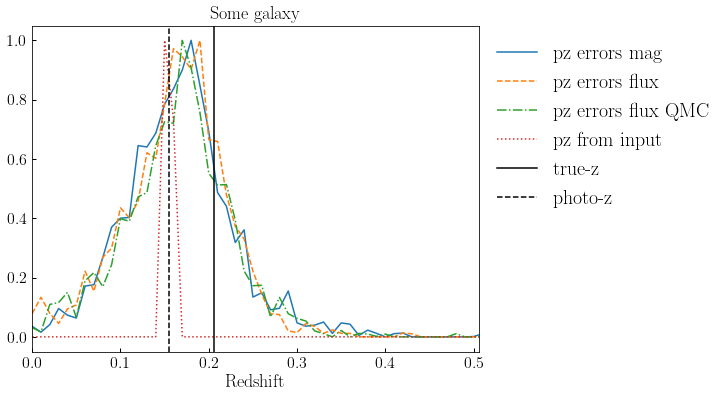

In [28]:
ig = 0

photoz_orig = preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[sel,0][ig]
truez = y_test[sel][ig]

dz = 0.3

plt.figure(figsize=(8,6))
plt.plot(zgrid, pz_mag[ig]/pz_mag[ig].max(), '-', label='pz errors mag')
plt.plot(zgrid, pz_flux[ig]/pz_flux[ig].max(), '--', label='pz errors flux')
plt.plot(zgrid, pz_flux_QMC[ig]/pz_flux_QMC[ig].max(), '-.', label='pz errors flux QMC')
plt.plot(zgrid, pz[sel][ig]/pz[sel][ig].max(), ':', label='pz from input' )
plt.axvline(truez, color='k',ls='-', label='true-z')
plt.axvline(photoz_orig, color='k',ls='--', label='photo-z')
plt.xlim(max(truez-dz,0.0), truez+dz)
plt.xlabel('Redshift')
plt.title('Some galaxy')
plt.legend(loc=2, fontsize=20, bbox_to_anchor=(1.,1.))
#plt.yscale('log')
#plt.savefig('dummy_test_2.png',bbox_inches='tight', dpi=300)
plt.show()

In [29]:
fluxes, fluxes_err = pzerrors.mag2flux(features_test, features_error_test)

samples = pzerrors.get_normal_qmc_samples(fluxes, fluxes_err, 100)
samples.shape, fluxes.shape

((100, 249, 5), (249, 5))

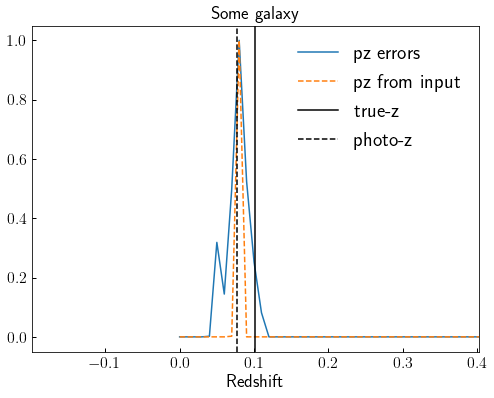

In [31]:
ig = 35

photoz_orig = preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[sel,0][ig]
truez = y_test[sel][ig]

dz = 0.3

plt.figure(figsize=(8,6))
plt.plot(zgrid, pz_final[ig]/pz_final[ig].max(), '-', label='pz errors')
plt.plot(zgrid, pz[sel][ig]/pz[sel][ig].max(), '--', label='pz from input' )
plt.axvline(truez, color='k',ls='-', label='true-z')
plt.axvline(photoz_orig, color='k',ls='--', label='photo-z')
plt.xlim(truez-dz, truez+dz)
plt.xlabel('Redshift')
plt.title('Some galaxy')
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.savefig('dummy_test_2.png',bbox_inches='tight', dpi=300)
plt.show()

In [78]:
def approximate_likelihood(ztrue, Nreal, f, fe, cutoff):
    
    photoz = np.zeros((Nreal,len(f)))
    for i in range(Nreal):
        f_real = np.random.normal(f, fe)

        ## Prediction 
        f_real = preproc.transform(f_real)
        y_pred = np.array(model_train(f_real))


        y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
        y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]

        photoz[i] = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
        #plt.scatter(ztrue, photoz[i], s=1)
        #plt.show()
        #plt.hist((photoz[i]-ztrue)/(1+ztrue), np.arange(-0.1+0.01/2.,0.1,0.01), histtype='step')
        #plt.show()
        
    mean_z = np.mean(photoz,axis=0)
    std_z = np.std(photoz,axis=0, ddof=1)
    
    like = norm.pdf(ztrue, loc=mean_z, scale=std_z)
    like = np.clip(like,1e-200,np.inf)
    like_max = norm.pdf(mean_z, loc=mean_z, scale=std_z)
    loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
    loglike = np.clip(loglike, -np.inf, cutoff)
    return loglike

In [37]:
def prediction_zp(xdata, xzero):
 
    f_real = xdata.copy()
    f_real[:,:4] = f_real[:,:4] + xzero
    f_real = preproc.transform(f_real)
    y_pred = np.array(model_train(f_real))


    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]

    photoz = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
    return photoz

In [79]:
sel = (label_test==0)&(y_test>0.01)&(X_test_orig[:,4]<17)

extra_cov = (5.)**2
Nreal = 10
cutoff = 5

Nchain = 1000


xchain = []
P = []

xtest = np.zeros(4)
xdata = X_test_orig[sel].copy()
xdata[:,:4] = xdata[:,:4] + xtest
result = approximate_likelihood(y_test[sel], 
                                Nreal,
                                xdata,
                                X_err[sel],
                                cutoff
                               )
    
xchain.append(xtest)
P.append(result.sum())
print(-1, xchain[0], P[0])

for i in range(Nchain):
    xtest = xchain[i] + np.random.normal(0,0.005, 4)
    
    
    xdata = X_test_orig[sel].copy()
    xdata[:,:4] = xdata[:,:4] + xtest
    result = approximate_likelihood(y_test[sel], 
                                    Nreal,
                                    xdata,
                                    X_err[sel],
                                    cutoff
                                   )
    
    
    #print(np.exp(-0.5*(result.sum()-P[i])))
    #print(np.exp(-0.5*(result.sum()-P[i])/extra_cov))
    #A = min(1, np.exp(-0.5*(result.sum()-P[i])))
    A = min(1, np.exp(-0.5*(result.sum()-P[i])/extra_cov))
    R = np.random.rand(1)[0]
    
    if R <= A:
        xchain.append(xtest)
        P.append(result.sum())
    else:
        xchain.append(xchain[i])
        P.append(P[i])
        
    print(i, np.round(xchain[i+1],4), np.round(P[i+1],2))
    

-1 [0. 0. 0. 0.] 1357.1656425656265
0 [-0.0042  0.0085  0.0012  0.002 ] 1316.4
1 [ 0.0024  0.0102 -0.0018  0.0017] 1328.54
2 [ 0.0016  0.0094 -0.0042 -0.0012] 1307.89
3 [ 0.0079  0.016  -0.0014  0.0034] 1287.74
4 [ 0.012   0.0164 -0.0005 -0.005 ] 1250.84
5 [ 0.0138  0.0154  0.0021 -0.    ] 1312.07
6 [ 0.0142  0.0223 -0.0028 -0.0009] 1262.3
7 [0.0158 0.0233 0.0033 0.0002] 1242.66
8 [0.0158 0.0233 0.0033 0.0002] 1242.66
9 [ 0.0238  0.0265  0.0025 -0.0107] 1205.83
10 [ 0.0298  0.0197  0.0083 -0.0142] 1262.43
11 [ 0.0298  0.0197  0.0083 -0.0142] 1262.43
12 [ 0.0256  0.014   0.0114 -0.0203] 1274.25
13 [ 0.0256  0.014   0.0114 -0.0203] 1274.25
14 [ 0.0279  0.0097  0.019  -0.0268] 1278.92
15 [ 0.0306  0.0159  0.0182 -0.0295] 1255.16
16 [ 0.0249  0.0225  0.0221 -0.032 ] 1233.32
17 [ 0.0248  0.0252  0.0138 -0.034 ] 1176.42
18 [ 0.0166  0.0272  0.018  -0.0418] 1118.26
19 [ 0.0099  0.0237  0.0114 -0.0471] 1086.73
20 [ 0.0096  0.0324  0.0081 -0.0469] 1039.29
21 [ 0.0096  0.0324  0.0081 -0.0469] 10

KeyboardInterrupt: 

In [77]:
sel = (label_test==0)&(y_test>0.01)&(X_test_orig[:,4]<17)

extra_cov = (5.)**2
Nreal = 10
cutoff = 5

Nchain = 1000


xchain = []
P = []

xtest = np.zeros(4)
xdata = X_test_orig[sel].copy()
xdata[:,:4] = xdata[:,:4] + xtest
result = approximate_likelihood(y_test[sel], 
                                Nreal,
                                xdata,
                                X_err[sel],
                                cutoff
                               )
    
xchain.append(xtest)
P.append(result.sum())
print(-1, xchain[0], P[0])

for i in range(Nchain):
    xtest = xchain[i] + np.random.normal(0,0.005, 4)
    
    
    xdata = X_test_orig[sel].copy()
    xdata[:,:4] = xdata[:,:4] + xtest
    result = approximate_likelihood(y_test[sel], 
                                    Nreal,
                                    xdata,
                                    X_err[sel],
                                    cutoff
                                   )
    
    
    #print(np.exp(-0.5*(result.sum()-P[i])))
    #print(np.exp(-0.5*(result.sum()-P[i])/extra_cov))
    #A = min(1, np.exp(-0.5*(result.sum()-P[i])))
    A = min(1, np.exp(-0.5*(result.sum()-P[i])/extra_cov))
    R = np.random.rand(1)[0]
    
    if R <= A:
        xchain.append(xtest)
        P.append(result.sum())
    else:
        xchain.append(xchain[i])
        P.append(P[i])
        
    print(i, np.round(xchain[i+1],4), np.round(P[i+1],2))
    

-1 [0. 0. 0. 0.] 1362.7319096052906
0 [-0.0132  0.0021 -0.0002 -0.0025] 1300.98
1 [-0.0161  0.0053  0.0007 -0.0031] 1271.97
2 [-0.0132  0.0133 -0.001  -0.0091] 1193.96
3 [-0.017   0.0155 -0.005  -0.008 ] 1177.27
4 [-0.017   0.0155 -0.005  -0.008 ] 1177.27
5 [-0.0146  0.0152 -0.0124 -0.0078] 1154.77
6 [-0.0162  0.0168 -0.0224 -0.0119] 1124.67
7 [-0.0065  0.0205 -0.0168 -0.015 ] 1108.35
8 [-0.0043  0.0164 -0.026  -0.0135] 1109.55
9 [-0.0043  0.0164 -0.026  -0.0135] 1109.55
10 [-0.0003  0.0213 -0.0311 -0.0073] 1104.31
11 [ 0.0006  0.0284 -0.0276 -0.0086] 1057.34
12 [ 0.0046  0.0322 -0.0287 -0.0127] 1062.29
13 [ 0.0034  0.0303 -0.0299 -0.0069] 1069.92
14 [-0.0006  0.0265 -0.0377 -0.005 ] 1099.18
15 [-0.0085  0.0416 -0.0435 -0.0062] 963.29
16 [-0.0085  0.0416 -0.0435 -0.0062] 963.29
17 [-0.006   0.0492 -0.0421  0.0006] 954.97
18 [-0.0059  0.0522 -0.0399 -0.0032] 947.71
19 [-0.0014  0.0491 -0.0339  0.0039] 973.83
20 [-0.0129  0.051  -0.034   0.0047] 981.35
21 [-0.009   0.0453 -0.0423  0.0079

182 [-0.1499  0.0363 -0.0432  0.0105] 992.29
183 [-0.1439  0.0332 -0.0457  0.013 ] 978.47
184 [-0.1435  0.0271 -0.0453  0.0121] 973.93
185 [-0.1503  0.0264 -0.046   0.01  ] 950.91
186 [-0.1487  0.0284 -0.0451  0.0097] 951.92
187 [-0.1532  0.0259 -0.0495  0.0168] 965.1
188 [-0.1535  0.0188 -0.0487  0.023 ] 960.82
189 [-0.1535  0.0188 -0.0487  0.023 ] 960.82
190 [-0.1509  0.0163 -0.0527  0.0317] 981.44
191 [-0.1531  0.0156 -0.0464  0.0333] 971.17
192 [-0.1578  0.0182 -0.0421  0.0306] 972.99
193 [-0.1578  0.0182 -0.0421  0.0306] 972.99
194 [-0.1562  0.0132 -0.0418  0.0254] 976.14
195 [-0.1558  0.0178 -0.0363  0.017 ] 969.4
196 [-0.1608  0.0184 -0.0485  0.0155] 966.34
197 [-0.1634  0.0178 -0.0572  0.0129] 978.9
198 [-0.1732  0.0149 -0.0557  0.0153] 942.69
199 [-0.1732  0.0149 -0.0557  0.0153] 942.69
200 [-0.1746  0.02   -0.0467  0.0178] 973.54
201 [-0.1703  0.0186 -0.0426  0.0209] 946.42
202 [-0.1703  0.0186 -0.0426  0.0209] 946.42
203 [-0.1703  0.0059 -0.0534  0.0224] 1004.79
204 [-0.174 

363 [-0.1971 -0.0142 -0.0994 -0.0105] 1000.32
364 [-0.1963 -0.0177 -0.1029 -0.0164] 1015.2
365 [-0.1963 -0.0177 -0.1029 -0.0164] 1015.2
366 [-0.1941 -0.0185 -0.1004 -0.0178] 991.31
367 [-0.1872 -0.0212 -0.0964 -0.0253] 995.69
368 [-0.187  -0.017  -0.1044 -0.0276] 1014.97
369 [-0.1841 -0.0182 -0.0992 -0.0321] 1042.0
370 [-0.184  -0.0187 -0.0991 -0.0266] 1007.54
371 [-0.1887 -0.017  -0.1012 -0.0266] 1033.13
372 [-0.1923 -0.0102 -0.101  -0.0281] 1059.44
373 [-0.1936 -0.0113 -0.1009 -0.0329] 1062.06
374 [-0.1936 -0.0113 -0.1009 -0.0329] 1062.06
375 [-0.2058 -0.0138 -0.0967 -0.0362] 1100.68
376 [-0.2058 -0.0138 -0.0967 -0.0362] 1100.68
377 [-0.2049 -0.0129 -0.0888 -0.0306] 1032.19
378 [-0.1946 -0.017  -0.0934 -0.0273] 1041.67
379 [-0.1912 -0.0149 -0.0908 -0.0258] 1029.82
380 [-0.2003 -0.0227 -0.0942 -0.0238] 1019.28
381 [-0.1991 -0.0277 -0.0929 -0.0286] 1042.95
382 [-0.1997 -0.0343 -0.0886 -0.0207] 991.87
383 [-0.1907 -0.0364 -0.0905 -0.0194] 1002.79
384 [-0.1888 -0.0437 -0.0864 -0.0237] 97

545 [-0.1708 -0.0388 -0.1082 -0.0333] 970.56
546 [-0.1708 -0.0388 -0.1082 -0.0333] 970.56
547 [-0.1689 -0.0371 -0.1045 -0.0337] 978.31
548 [-0.1689 -0.0371 -0.1045 -0.0337] 978.31
549 [-0.1706 -0.0317 -0.1091 -0.0333] 991.41
550 [-0.1717 -0.0261 -0.1042 -0.0419] 1025.5
551 [-0.1768 -0.0314 -0.1039 -0.0447] 1013.02
552 [-0.1768 -0.0314 -0.1039 -0.0447] 1013.02
553 [-0.1768 -0.0314 -0.1039 -0.0447] 1013.02
554 [-0.1768 -0.0314 -0.1039 -0.0447] 1013.02
555 [-0.1748 -0.039  -0.1069 -0.0441] 1000.38
556 [-0.175  -0.0376 -0.1056 -0.044 ] 1016.98
557 [-0.1738 -0.0395 -0.1055 -0.0426] 975.73
558 [-0.1822 -0.0357 -0.1021 -0.0414] 997.95
559 [-0.1723 -0.0392 -0.1022 -0.0491] 989.58
560 [-0.1867 -0.0444 -0.0979 -0.0436] 950.43
561 [-0.1781 -0.0462 -0.0942 -0.0452] 949.55
562 [-0.1781 -0.0466 -0.0913 -0.04  ] 948.7
563 [-0.1739 -0.0415 -0.0879 -0.0428] 957.26
564 [-0.1739 -0.0415 -0.0879 -0.0428] 957.26
565 [-0.1775 -0.0393 -0.0816 -0.0413] 938.09
566 [-0.1775 -0.0393 -0.0816 -0.0413] 938.09
567 [

726 [-0.2242  0.024  -0.0335  0.0097] 1023.9
727 [-0.2336  0.0258 -0.0259  0.009 ] 1031.8
728 [-0.2339  0.0272 -0.0224  0.016 ] 1030.33
729 [-0.2412  0.0253 -0.0169  0.0169] 1029.65
730 [-0.2401  0.0263 -0.0107  0.0134] 1033.22
731 [-0.2417  0.0214 -0.0067  0.0235] 977.32
732 [-0.2455  0.0122 -0.0008  0.0173] 968.47
733 [-0.2488  0.0124 -0.0135  0.0232] 962.94
734 [-0.2531  0.0143 -0.003   0.026 ] 977.3
735 [-0.2494  0.0116 -0.0038  0.0273] 953.0
736 [-0.2494  0.0116 -0.0038  0.0273] 953.0
737 [-0.2547  0.0085 -0.      0.0191] 942.18
738 [-0.2547  0.0085 -0.      0.0191] 942.18
739 [-0.256   0.0093  0.0066  0.0217] 971.34
740 [-0.2641  0.0094  0.0018  0.03  ] 969.29
741 [-0.2594  0.0046  0.0083  0.0318] 956.11
742 [-0.2489  0.0004  0.0117  0.0215] 946.94
743 [-0.2411  0.003   0.0041  0.0254] 976.94
744 [-0.245   0.0062  0.0118  0.0215] 981.41
745 [-0.2452  0.0109  0.0113  0.0182] 966.43
746 [-0.2426  0.018   0.0088  0.0265] 949.06
747 [-0.2426  0.018   0.0088  0.0265] 949.06
748 [-0.23

907 [-0.3113  0.0375  0.0498  0.1173] 1022.59
908 [-0.3124  0.0442  0.0444  0.1115] 1052.06
909 [-0.3124  0.0442  0.0444  0.1115] 1052.06
910 [-0.3132  0.0393  0.0479  0.1036] 1034.4
911 [-0.3134  0.0372  0.0457  0.1037] 1020.63
912 [-0.3134  0.0372  0.0457  0.1037] 1020.63
913 [-0.3145  0.0305  0.0499  0.0955] 1031.68
914 [-0.3058  0.0361  0.0578  0.0913] 1022.36
915 [-0.3058  0.0361  0.0578  0.0913] 1022.36
916 [-0.3061  0.0406  0.0599  0.0977] 1062.34
917 [-0.3061  0.0406  0.0599  0.0977] 1062.34
918 [-0.3026  0.0446  0.061   0.0952] 1047.97
919 [-0.3065  0.0425  0.064   0.0891] 1093.38
920 [-0.3037  0.0463  0.0705  0.0963] 1072.28
921 [-0.3122  0.0435  0.0746  0.1042] 1067.74
922 [-0.3091  0.0447  0.0685  0.0984] 1060.35
923 [-0.3122  0.048   0.0667  0.0992] 1083.02
924 [-0.3139  0.0503  0.0671  0.1063] 1054.35
925 [-0.3194  0.0463  0.0643  0.1039] 1051.53
926 [-0.3194  0.0463  0.0643  0.1039] 1051.53
927 [-0.3208  0.0458  0.063   0.1073] 1063.56
928 [-0.3172  0.0505  0.0663  0.108

In [79]:
xchain = np.array(xchain)
P = np.array(P)

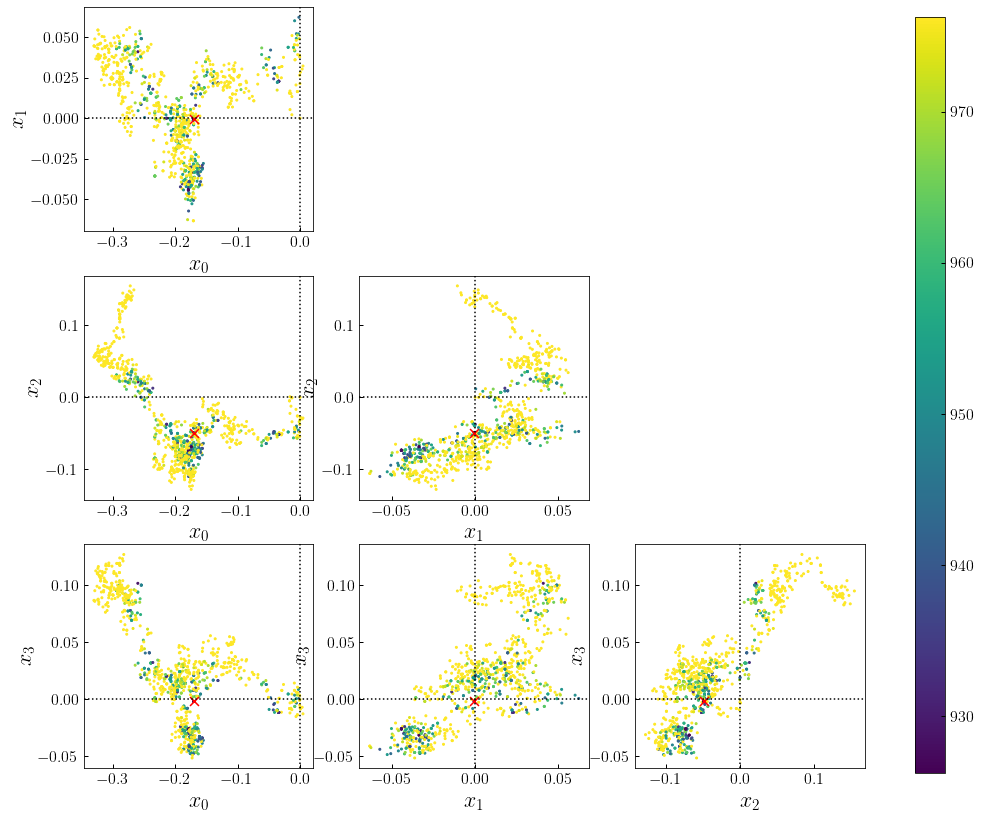

In [134]:
fig, ax = plt.subplots(3,3, figsize=(14,14))

for i in range(3):
    for j in range(3):
        if i<j:
            ax[i,j].axis('off')
            continue
            
        im = ax[i,j].scatter(xchain[:,j],xchain[:,i+1], s=4,c=P, vmin=P.min(), vmax=P.min()+50)
        argmin = P.argmin()
        ax[i,j].scatter(xchain[argmin,j],xchain[argmin,i+1], s=80, c='r', marker='x')
        ax[i,j].set_xlabel(f'$x_{j}$', fontsize=22)
        ax[i,j].set_ylabel(f'$x_{i+1}$', fontsize=22)
        ax[i,j].axvline(0, ls=':', color='k')
        ax[i,j].axhline(0, ls=':', color='k')
        
        #assert false
        
#fig.colorbar(im,ax=ax[i,j])
cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)
#fig.tight_layout()
plt.show()

In [ ]:
argmin = P.argmin()

argmin

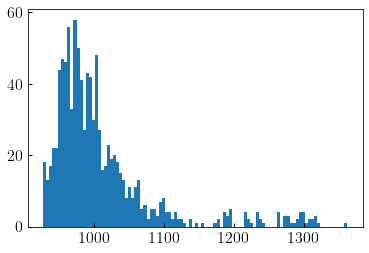

In [116]:
plt.hist(P,100);

In [132]:
def run_zp_chain(ztrue, f, fe, cutoff, extra_cov, Nreal, Nchain, x_init=None):

    xchain = []
    P = []

    if x_init is None:
        xtest = np.zeros(4)
    else:
        xtest = x_init.copy()
        
    xdata = f.copy()
    xdata[:,:4] = xdata[:,:4] + xtest
    result = approximate_likelihood(ztrue, 
                                    Nreal,
                                    xdata,
                                    fe,
                                    cutoff
                                   )

    xchain.append(xtest)
    P.append(result.sum())
    print(-1, xchain[0], P[0])

    for i in range(Nchain):
        xtest = xchain[i] + np.random.normal(0,0.005, 4)


        xdata = f.copy()
        xdata[:,:4] = xdata[:,:4] + xtest
        t0 = time.time()
        result = approximate_likelihood(ztrue, 
                                        Nreal,
                                        xdata,
                                        fe,
                                        cutoff
                                       )

        t1 = time.time()
        print(t1-t0)
        A = min(1, np.exp(-0.5*(result.sum()-P[i])/extra_cov))
        R = np.random.rand(1)[0]

        if R <= A:
            xchain.append(xtest)
            P.append(result.sum())
        else:
            xchain.append(xchain[i])
            P.append(P[i])

        print(i, np.round(xchain[i+1],4), np.round(P[i+1],2))
    
    xchain = np.array(xchain)
    P = np.array(P)
    return xchain, P


In [135]:
sel = (label_test==0)&(y_test>0.01)&(X_test_orig[:,4]<17)

extra_cov = (4.)**2
Nreal = 50
cutoff = 3

Nchain = 2

xchain2, P2 = run_zp_chain(
    y_test[sel],
    X_test_orig[sel].copy(), 
    X_err[sel], 
    cutoff, 
    extra_cov, 
    Nreal, 
    Nchain, 
    xchain[P.argmin()]
)

-1 [-0.17010429 -0.00049213 -0.04884318 -0.00181635] 638.3253012245244
13.305508136749268
0 [-0.1706  0.0064 -0.0442  0.0013] 646.06
13.324449062347412
1 [-0.1706  0.0064 -0.0442  0.0013] 646.06


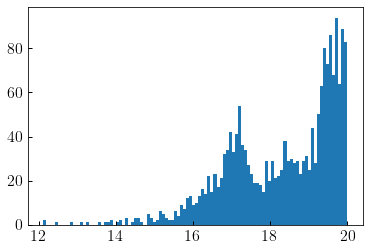

In [76]:
sel = label_test==0
plt.hist(X_test_orig[sel,4], 100);

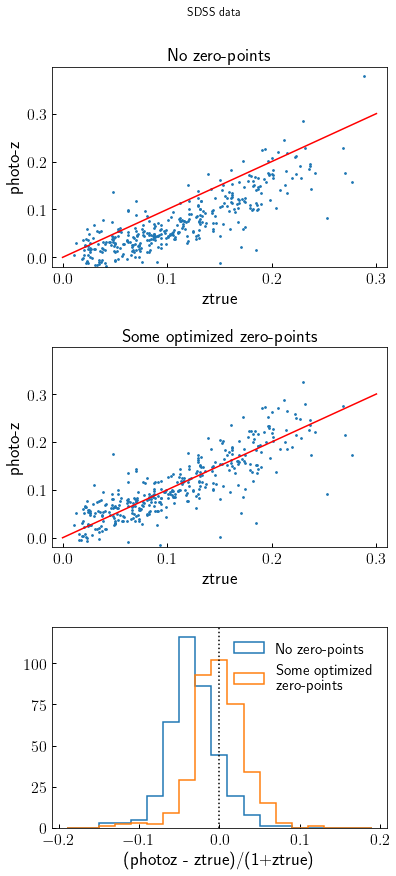

In [121]:
xdata = X_test_orig[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain[argmin])
zb_zp = prediction_zp(xdata, xchain[argmin])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0,0.3],[0,0.3], color='r')
ax[0].set_xlim(-0.01,0.3+0.01)
ax[0].set_ylim(-0.02,zb_0.max()+0.02)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0,0.3],[0,0.3], color='r')
ax[1].set_xlim(-0.01,0.3+0.01)
ax[1].set_ylim(-0.02,zb_0.max()+0.02)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.2+dz_bins/2., 0.2, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('SDSS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

In [89]:
def loggauss(zvals, mu, sigma, weight):
    exp = -0.5 * (zvals - mu)**2/sigma**2
    return np.log(weight / (sigma * np.sqrt(2*np.pi))) + exp

def gaussian_vect(zgrid, mu, sigma, weight):
    exp = np.exp(-0.5 * np.add.outer(zgrid, -mu)**2/sigma**2)
    return weight / (sigma * np.sqrt(2*np.pi)) * exp

def exact_likelihood(
    preproc, 
    preproc_y, 
    model_train, 
    ztrue, 
    f, 
    fe, 
    Nintegral,
    cutoff,
    zgrid,
    ztrue_arg
):
    """Function to calculate the likelihood for the zero points.
    Calculates p(z|f) = sum_F p(F|f) * p(z|F) by drawing from p(F|f),
    calculating p(z|F) with MDN, and summing the importance sampled F points.
    
    Parameters
    ----------
    preproc : callable
        Rescaling function for magnitudes and colors.
        
    preproc_y : callable
        Rescaling function for redshift.
        
    model_train : callable
        MDN trained network.
    
    ztrue : ndarray of shape (n_galaxies, )
        Array with the true redshift.
        
    f : ndarray of shape (n_galaxies, n_features)
        Array with the input features.
        
    fe : ndarray of shape (n_galaxies, n_features)
        Array with the error of the input features.   
    
    Nintegral : int
        Number of samples to integrate the photometric noise. 
        
    cutoff : float
        Number of sigmas (roughly) at where to clip the likelihood of outlier galaxies. Default is 5.
        
    zgrid : ndarray of shape (n_grid).
        Redshift grid to perform the exact likelihood computation. 

    ztrue_arg : ndarray of shape (n_galaxies, ).
        Nearest positional argument of ztrue in zgrid.
        
    Returns
    -------
    loglike : ndarray of shape (n_galaxies, )
        The zero point loglikelihood value for each galaxy   
    """
    
    pz = np.zeros((Nintegral,len(f),len(zgrid)))
    
    for i in range(Nintegral):
        f_real = np.random.normal(f, fe)
        
        f_real = preproc.transform(f_real)
        y_pred = np.array(model_train(f_real))
        
        weight = y_pred[2]
        mu = y_pred[0]
        sig = np.sqrt(np.log(y_pred[1]))

        mu = preproc_y.inverse_transform(mu)
        sig = preproc_y.inverse_transform(sig)
        sig = np.clip(sig,0.001, np.inf)
        
        zipped = zip(mu.T, 
                 sig.T, 
                 weight.T)
        
        pzsub = np.sum([gaussian_vect(zgrid, m,s,w) for (m,s,w) in zipped], axis=0).T
        sum_pz = np.sum(pzsub,axis=1)[:,None]
        sum_pz[sum_pz==0] = 1.
        pzsub /= sum_pz
        pz[i] = pzsub
        
    pz = np.sum(pz,axis=0)
    sum_pz = np.sum(pz,axis=1)[:,None]
    sum_pz[sum_pz==0] = 1.
    pz /= sum_pz
    
    argmax = np.argmax(pz,axis=1)
    like_max = pz[range(len(argmax)), argmax]
    like = pz[range(len(ztrue)), ztrue_arg]
    
    loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
    loglike = np.clip(loglike, -np.inf, cutoff)
    loglike[np.isnan(loglike)] = cutoff
    return loglike
    
def approximate_likelihood(
    preproc, 
    preproc_y, 
    model_train, 
    ztrue, 
    f, 
    fe, 
    Nintegral,
    cutoff
):
    """Function to calculate an approximate likelihood for the zero points.
    Assumes p(z|f) = sum_F p(F|f) * p(z|F) to be a Gaussian distribution.
    F values are drawn from p(F|f), and the most z value from MDN, p(z|F), 
    is stored: {z}. The average and variance of {z} determines a Gaussian, p(z|f).
    
    Parameters
    ----------
    preproc : callable
        Rescaling function for magnitudes and colors.
        
    preproc_y : callable
        Rescaling function for redshift.
        
    model_train : callable
        MDN trained network.
    
    ztrue : ndarray of shape (n_galaxies, )
        Array with the true redshift.
        
    f : ndarray of shape (n_galaxies, n_features)
        Array with the input features.
        
    fe : ndarray of shape (n_galaxies, n_features)
        Array with the error of the input features.   
    
    Nintegral : int
        Number of samples to integrate the photometric noise. 
        
    cutoff : float
        Number of sigmas (roughly) at where to clip the likelihood of outlier galaxies. Default is 5.
        
    Returns
    -------
    loglike : ndarray of shape (n_galaxies, )
        The zero point loglikelihood value for each galaxy
    """

    photoz = np.zeros((Nintegral,len(f)))
    for i in range(Nintegral):
        f_real = np.random.normal(f, fe)

        ## Prediction 
        f_real = preproc.transform(f_real)
        y_pred = np.array(model_train(f_real))

        y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
        y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
        #y_pred_arg = np.argmax(y_pred[2], axis = 1)
        #y_pred_mean = y_pred[0][range(len(y_pred_arg)), y_pred_arg]

        photoz[i] = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
        
    mean_z = np.mean(photoz,axis=0)
    std_z = np.std(photoz,axis=0, ddof=1)
    
    like = norm.pdf(ztrue, loc=mean_z, scale=std_z)
    like = np.clip(like,1e-200,np.inf)
    like_max = norm.pdf(mean_z, loc=mean_z, scale=std_z)
    loglike = -2.0*np.log(like) + 2.0 * np.log(like_max)
    loglike = np.clip(loglike, -np.inf, cutoff)
    loglike[np.isnan(loglike)] = cutoff
    return loglike

def _likelihood_wrapper(
    preproc, 
    preproc_y, 
    model_train, 
    ztrue, 
    f, 
    fe, 
    Nintegral,
    method,
    cutoff,
    zgrid, 
    ztrue_arg
):
    """Function wrapper to call the appropriate likelihood function to integrate 
    the photometric noise.
 
    Parameters
    ----------
    preproc : callable
        Rescaling function for magnitudes and colors.
        
    preproc_y : callable
        Rescaling function for redshift.
        
    model_train : callable
        MDN trained network.
    
    ztrue : ndarray of shape (n_galaxies, )
        Array with the true redshift.
        
    f : ndarray of shape (n_galaxies, n_features)
        Array with the input features.
        
    fe : ndarray of shape (n_galaxies, n_features)
        Array with the error of the input features.   
    
    Nintegral : int
        Number of samples to integrate the photometric noise.
    
    method : str
        Method to integrate the photometric noise. Options are 'exact' or 'approximate'.
        
    cutoff : float
        Number of sigmas (approx) at where to clip the likelihood of outlier galaxies. Default is 5.
        
    zgrid : ndarray of shape (n_grid).
        Redshift grid to perform the exact likelihood computation. 

    ztrue_arg : ndarray of shape (n_galaxies, ).
        Nearest positional argument of ztrue in zgrid.
        
    Returns
    -------
    loglike : ndarray of shape (n_galaxies, )
        The zero point loglikelihood value for each galaxy
    """
    
    if (method == "exact"):
        return exact_likelihood(preproc, preproc_y, model_train, ztrue, f, fe, Nintegral, 
                                cutoff, zgrid, ztrue_arg)
        
    elif (method == "approximate"):
        return approximate_likelihood(preproc, preproc_y, model_train, ztrue, f, fe, Nintegral, cutoff)

def run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    ztrue, 
    f, 
    fe, 
    Nintegral,
    Nchain,
    method = "exact",
    params_init = None,
    cutoff = 5., 
    extra_cov = 9.,
    step_size = 0.005,
    zgrid = None
):
    """Function that runs an MCMC over the zero-point space. Runs a Metropolis-Hastings walk 
    with a Gaussian function as the proposal distribution. With zeropoints aka 'zp' and some
    data:
    -- p(zp|data) propto p(data|zp) * p(zp)
    We assume p(zp) to be uniform for now.
    -- p(data|zp) = p(ztrue|f, zp)
 
    Parameters
    ----------
    preproc : callable
        Rescaling function for magnitudes and colors.
        
    preproc_y : callable
        Rescaling function for redshift.
        
    model_train : callable
        MDN trained network.
    
    ztrue : ndarray of shape (n_galaxies, )
        Array with the true redshift.
        
    f : ndarray of shape (n_galaxies, n_features)
        Array with the input features.
        
    fe : ndarray of shape (n_galaxies, n_features)
        Array with the error of the input features.   
    
    Nintegral : int
        Number of samples to integrate the photometric noise.
    
    Nchain : int
        Number of steps in the zero-point chain.
        
    method : str
        Method to integrate the photometric noise. Options are 'exact' or 'approximate'.
        
    params_init : ndarray of shape (n_params, )
        Initial guess at the parameters. Default is zero.
        
    cutoff : float
        Number of sigmas (approx) at where to clip the likelihood of outlier galaxies. Default is 5.
        
    extra_cov : float
        Factor to increase the nominal variance of the zero-point likelihood. Default is 3**2.
        
    step_size : float
        Width size of the Gaussian proposal for the MCMC. Default is 0.005
        
    zgrid : ndarray of shape (n_grid). Optional.
        Redshift grid to perform the exact likelihood computation.
        
    Returns
    -------
    chain : ndarray of shape (n_iterations, n_params)
        The values of the zero point params at each step
    P : ndarray of shape (n_iterations, )
        The value of the zero point likelihood at each step
    """
    
    if (method != "exact") & (method != "approximate"):
        raise NotImplementedError("Method has to be either 'exact' or 'approximate'.")
        
    if method == "exact":
        ztrue_arg = np.argmin(np.add.outer(ztrue,-zgrid)**2,axis=1)
    else:
        ztrue_arg = None
    
    n_params = f.shape[1] - 1
    if params_init is None:
        params_init = np.zeros(n_params)
    
    chain = np.zeros((Nchain, n_params))
    P = np.zeros(Nchain)

    params = params_init.copy()
    xdata = f.copy()
    xdata[:,:4] = xdata[:,:4] + params
    t0 = time.time()
    loglike = _likelihood_wrapper(preproc, preproc_y, model_train, ztrue, xdata, fe, Nintegral, 
                                 method, cutoff, zgrid, ztrue_arg)
    t1 = time.time()
    chain[0] = params
    P[0] = loglike.sum()
    print(t1-t0)
    print(0, np.round(chain[0],4), np.round(P[0],2))

    for i in range(Nchain-1):
        params = chain[i] + np.random.normal(0, step_size, n_params)

        xdata = f.copy()
        xdata[:,:4] = xdata[:,:4] + params
        t0 = time.time()
        loglike = _likelihood_wrapper(preproc, preproc_y, model_train, ztrue, xdata, fe, Nintegral, 
                                     method, cutoff, zgrid, ztrue_arg)
        t1 = time.time()
        
        A = min(1, np.exp(-0.5*(loglike.sum()-P[i])/extra_cov))
        R = np.random.rand(1)[0]

        if R <= A:
            chain[i+1] = params
            P[i+1] = loglike.sum()
        else:
            chain[i+1] = chain[i]
            P[i+1] = P[i]

        print(t1-t0)
        print(i, np.round(chain[i+1],4), np.round(P[i+1],2))
    

    return chain, P


In [90]:
zgrid = np.arange(-0.1,0.8,0.01)

sel = (label_test==0)&(y_test>0.01)#&(X_test_orig[:,4]<17)
#sel = (label_test==0)&(y_test>0.02)&(y_test<0.4)&(X_test_orig[:,4]<17.)

extra_cov = (7.)**2
Nintegral = 10
cutoff = 5

Nchain = 100

errors = X_err[sel].copy()
#errors = np.sqrt(errors**2 + 0.02**2)

pinit = [-0.2642,  0.0437,  0.0197,  0.0851]

xchain2, P2 = run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    X_test_orig[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    method = "exact",
    #method = "approximate",
    params_init = None,
    #params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = 0.005,
    zgrid = zgrid
)

/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.185851097106934
0 [0. 0. 0. 0.] 7433.52


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


14.95833706855774
0 [0. 0. 0. 0.] 7433.52


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.914905786514282
1 [-0.0012  0.0045 -0.0055 -0.0063] 7367.07


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.960393905639648
2 [-0.0012  0.0045 -0.0055 -0.0063] 7367.07


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.839531898498535
3 [ 0.0037  0.0033 -0.0122 -0.0091] 7362.85


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.955902099609375
4 [ 0.0023  0.0052 -0.0177 -0.013 ] 7306.05


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.981612920761108
5 [-0.0055  0.0101 -0.0167 -0.0067] 7332.55


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.827240943908691
6 [ 0.0027  0.0051 -0.0173 -0.0111] 7286.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.445770978927612
7 [ 0.005   0.0042 -0.0171 -0.0117] 7275.02


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


14.964916944503784
8 [ 0.0054  0.0035 -0.0201 -0.0177] 7295.73


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.919327974319458
9 [ 0.0054  0.0035 -0.0201 -0.0177] 7295.73


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.876919984817505
10 [ 0.0054  0.0035 -0.0201 -0.0177] 7295.73


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.93994927406311
11 [-0.0003  0.0133 -0.0201 -0.0194] 7269.14


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.904186964035034
12 [-0.0055  0.0135 -0.0185 -0.0107] 7255.06


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.86570405960083
13 [-0.0003  0.0143 -0.0209 -0.0089] 7298.64


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.854669094085693
14 [-0.0011  0.0108 -0.0229 -0.0243] 7233.26


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.177120208740234
15 [ 0.0087  0.0114 -0.0171 -0.0235] 7273.81


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.931223154067993
16 [ 0.0025  0.0113 -0.0138 -0.0305] 7219.33


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.268660068511963
17 [ 0.0085  0.0202 -0.0206 -0.0352] 7168.99


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.794204235076904
18 [ 0.0014  0.0151 -0.031  -0.0365] 7196.0


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.31696605682373
19 [ 0.0005  0.0128 -0.0243 -0.0343] 7206.97


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


16.92428994178772
20 [-0.0032  0.008  -0.022  -0.0348] 7141.68


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.42044997215271
21 [-0.0032  0.008  -0.022  -0.0348] 7141.68


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.53370213508606
22 [-0.0032  0.008  -0.022  -0.0348] 7141.68


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.770915031433105
23 [-0.0014  0.0176 -0.0292 -0.0373] 7206.42


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.664856910705566
24 [ 0.0075  0.0089 -0.031  -0.0448] 7183.34


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.310427188873291
25 [ 0.0115 -0.0034 -0.0346 -0.0365] 7206.32


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.759408712387085
26 [ 0.0224  0.0009 -0.0338 -0.0312] 7370.96


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.292716026306152
27 [ 0.0224  0.0009 -0.0338 -0.0312] 7370.96


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.468778133392334
28 [ 0.0285  0.0104 -0.0367 -0.0266] 7249.37


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.872545957565308
29 [ 0.038   0.008  -0.0331 -0.0216] 7279.85


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


14.840338945388794
30 [ 0.0291  0.0277 -0.0326 -0.0182] 7116.74


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.759176969528198
31 [ 0.0291  0.0277 -0.0326 -0.0182] 7116.74


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.771063804626465
32 [ 0.0277  0.0289 -0.0388 -0.0199] 7091.77


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.824801683425903
33 [ 0.0277  0.0289 -0.0388 -0.0199] 7091.77


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.744234085083008
34 [ 0.0374  0.0275 -0.0426 -0.0298] 7022.26


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.887681007385254
35 [ 0.0401  0.0191 -0.04   -0.0403] 7150.33


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.727413177490234
36 [ 0.0401  0.0191 -0.04   -0.0403] 7150.33


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


14.598095893859863
37 [ 0.0379  0.0164 -0.046  -0.0491] 7091.99


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.399532079696655
38 [ 0.0379  0.0164 -0.046  -0.0491] 7091.99


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.522695779800415
39 [ 0.0405  0.0157 -0.0502 -0.0567] 7091.55


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.657137870788574
40 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.278629779815674
41 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.03109097480774
42 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.953758239746094
43 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.881731748580933
44 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.031288146972656
45 [ 0.0388  0.0107 -0.0459 -0.0607] 7001.91


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.163291215896606
46 [ 0.0413  0.0144 -0.0434 -0.0674] 7131.75


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.977282047271729
47 [ 0.0471  0.0144 -0.0464 -0.0607] 7072.04


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.176689863204956
48 [ 0.0427  0.0196 -0.0378 -0.0574] 7087.62


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.396108150482178
49 [ 0.0375  0.0313 -0.0393 -0.0557] 7025.63


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.844846725463867
50 [ 0.0435  0.0405 -0.039  -0.0532] 7157.69


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


16.90717601776123
51 [ 0.0392  0.04   -0.0399 -0.0508] 7154.55


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.091965913772583
52 [ 0.0346  0.0385 -0.0357 -0.0532] 7156.83


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.391472816467285
53 [ 0.0408  0.0424 -0.0404 -0.0581] 7073.92


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.822029113769531
54 [ 0.0334  0.0386 -0.0393 -0.0606] 7080.04


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.30104398727417
55 [ 0.0334  0.0386 -0.0393 -0.0606] 7080.04


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.764439105987549
56 [ 0.0378  0.0407 -0.0406 -0.0569] 7031.55


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.106121063232422
57 [ 0.0466  0.043  -0.0379 -0.0517] 7040.55


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.347759008407593
58 [ 0.0419  0.0503 -0.0397 -0.0535] 7141.13


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.963701963424683
59 [ 0.0419  0.0503 -0.0397 -0.0535] 7141.13


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.428489923477173
60 [ 0.0419  0.0503 -0.0397 -0.0535] 7141.13


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.40843915939331
61 [ 0.0493  0.0464 -0.033  -0.0565] 7063.23


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.915353059768677
62 [ 0.0493  0.0464 -0.033  -0.0565] 7063.23


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.110291004180908
63 [ 0.0494  0.0402 -0.0308 -0.0467] 7062.13


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.92281198501587
64 [ 0.0551  0.0382 -0.0283 -0.0504] 7065.74


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.057528734207153
65 [ 0.0621  0.0422 -0.0305 -0.0499] 7010.28


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.13328194618225
66 [ 0.0621  0.0422 -0.0305 -0.0499] 7010.28


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.3876531124115
67 [ 0.0621  0.0422 -0.0305 -0.0499] 7010.28


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.1179678440094
68 [ 0.0612  0.0409 -0.0342 -0.0508] 7127.31


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.37044668197632
69 [ 0.062   0.0441 -0.0367 -0.0462] 7127.82


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.013078927993774
70 [ 0.0656  0.0505 -0.0346 -0.0476] 7018.05


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


17.322773933410645
71 [ 0.0656  0.0505 -0.0346 -0.0476] 7018.05


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


17.041346073150635
72 [ 0.0642  0.0481 -0.039  -0.0486] 7012.6


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.09298872947693
73 [ 0.0687  0.0441 -0.0303 -0.0503] 7091.09


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.908104181289673
74 [ 0.0624  0.0475 -0.0349 -0.0505] 7113.61


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.624731302261353
75 [ 0.0591  0.0373 -0.0365 -0.0494] 6999.32


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


15.644722938537598
76 [ 0.0541  0.0355 -0.0369 -0.0428] 6955.33


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.70622181892395
77 [ 0.0559  0.0325 -0.0412 -0.0449] 7100.85


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.372645854949951
78 [ 0.0561  0.0359 -0.0431 -0.0432] 7117.96


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.250364780426025
79 [ 0.0515  0.04   -0.0378 -0.0454] 7048.61


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.769173860549927
80 [ 0.0515  0.0422 -0.0417 -0.0466] 6999.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.527773380279541
81 [ 0.0515  0.0422 -0.0417 -0.0466] 6999.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.63064193725586
82 [ 0.0472  0.044  -0.0393 -0.0466] 7084.8


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.903540849685669
83 [ 0.0472  0.044  -0.0393 -0.0466] 7084.8


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


16.054226875305176
84 [ 0.0469  0.0387 -0.0334 -0.0467] 7069.17


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.584455966949463
85 [ 0.0507  0.0325 -0.0331 -0.0467] 7054.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.588411331176758
86 [ 0.0507  0.0325 -0.0331 -0.0467] 7054.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.326311826705933
87 [ 0.0507  0.0325 -0.0331 -0.0467] 7054.11


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


15.72710132598877
88 [ 0.0519  0.0251 -0.0403 -0.0489] 7172.79


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


15.349786043167114
89 [ 0.0498  0.0265 -0.0316 -0.051 ] 7176.94


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.513453245162964
90 [ 0.0545  0.0214 -0.0352 -0.0581] 7118.37


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.757360219955444
91 [ 0.0629  0.0239 -0.0324 -0.0598] 7125.62


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


15.452507019042969
92 [ 0.0629  0.0239 -0.0324 -0.0598] 7125.62


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.517669200897217
93 [ 0.064   0.0193 -0.0427 -0.0579] 7113.36


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.173415184020996
94 [ 0.064   0.0193 -0.0427 -0.0579] 7113.36


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


15.156217098236084
95 [ 0.064   0.0193 -0.0427 -0.0579] 7113.36


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.049223184585571
96 [ 0.0619  0.0305 -0.0445 -0.066 ] 7026.7


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


15.189148187637329
97 [ 0.0619  0.0305 -0.0445 -0.066 ] 7026.7
15.20482611656189
98 [ 0.0619  0.0305 -0.0445 -0.066 ] 7026.7


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log
/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in add


In [ ]:
## Approximate:
0 [0. 0. 0. 0.] 1303.16

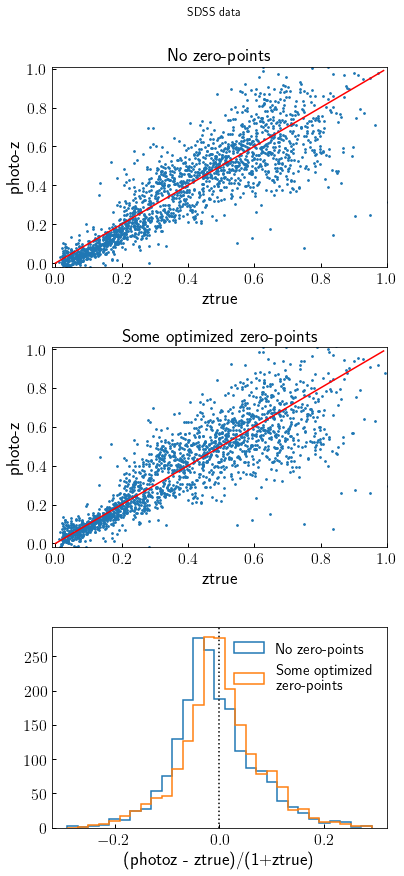

In [97]:
xdata = X_test_orig[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain2[P2.argmin()])
zb_zp = prediction_zp(xdata, xchain2[P2.argmin()])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0,0.99],[0,0.99], color='r')
ax[0].set_xlim(-0.01,0.99+0.01)
ax[0].set_ylim(-0.02,0.99+0.02)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0,0.99],[0,0.99], color='r')
ax[1].set_xlim(-0.01,0.99+0.01)
ax[1].set_ylim(-0.02,0.99+0.02)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.3+dz_bins/2., 0.3, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('SDSS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

In [118]:
zgrid = np.arange(-0.1,1.5,0.01)

sel = (label_test==1)&(y_test>0.01)#&(X_test_orig[:,4]<17)
#sel = (label_test==0)&(y_test>0.02)&(y_test<0.4)&(X_test_orig[:,4]<17.)

extra_cov = (6.)**2
Nintegral = 100
cutoff = 5

Nchain = 100

errors = X_err[sel].copy()
#errors = np.sqrt(errors**2 + 0.02**2)

pinit = [ 0.0679362 , -0.19639139, -0.05798437,  0.02100593]

xchain2, P2 = run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    X_test_orig[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    method = "exact",
    #method = "approximate",
    #params_init = None,
    params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = 0.005,
    zgrid = zgrid
)

/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


38.65434122085571
0 [ 0.0679 -0.1964 -0.058   0.021 ] 1576.0


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


35.405632972717285
0 [ 0.0604 -0.1882 -0.0608  0.0247] 1560.81


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


37.14526915550232
1 [ 0.0604 -0.1882 -0.0608  0.0247] 1560.81


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


38.8421471118927
2 [ 0.0634 -0.1971 -0.0616  0.0198] 1577.0


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


35.923765897750854
3 [ 0.0707 -0.1882 -0.0553  0.0202] 1581.04


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


36.105417013168335
4 [ 0.0723 -0.1858 -0.0532  0.0198] 1581.03


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


36.90418195724487
5 [ 0.0723 -0.1858 -0.0532  0.0198] 1581.03


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


36.716992139816284
6 [ 0.0695 -0.1853 -0.054   0.0181] 1558.65


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


38.13997173309326
7 [ 0.0683 -0.1862 -0.0549  0.0269] 1560.59


/Users/alarcon/anaconda3/anaconda3/envs/mdn/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log


35.71434998512268
8 [ 0.0707 -0.1933 -0.0606  0.0299] 1545.6


KeyboardInterrupt: 

In [117]:
xchain2[P2.argmin()]

array([ 0.0679362 , -0.19639139, -0.05798437,  0.02100593])

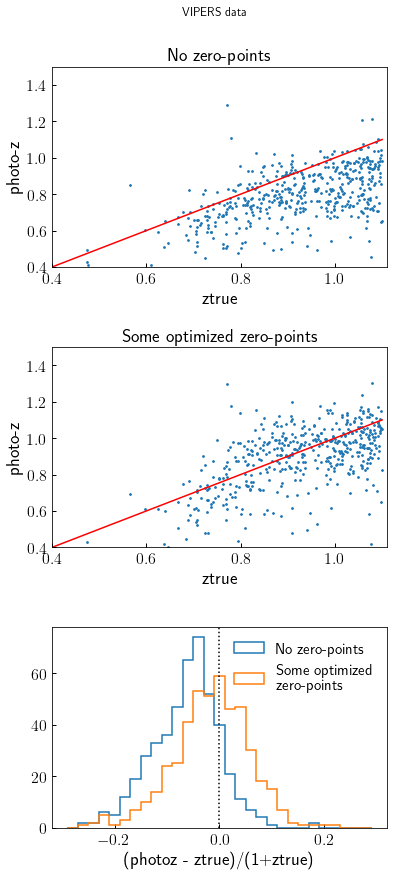

In [116]:
xdata = X_test_orig[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain2[P2.argmin()])
zb_zp = prediction_zp(xdata, xchain2[P2.argmin()])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0.4,1.1],[0.4,1.1], color='r')
ax[0].set_xlim(0.4,1.11)
ax[0].set_ylim(0.4,1.5)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0.4,1.1],[0.4,1.1], color='r')
ax[1].set_xlim(0.4,1.11)
ax[1].set_ylim(0.4,1.5)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.3+dz_bins/2., 0.3, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('VIPERS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

In [122]:
zgrid = np.arange(-0.1,1.5,0.01)

sel = (label_test==2)&(y_test>0.01)#&(X_test_orig[:,4]<17)
#sel = (label_test==0)&(y_test>0.02)&(y_test<0.4)&(X_test_orig[:,4]<17.)

extra_cov = (6.)**2
Nintegral = 10
cutoff = 5

Nchain = 2

errors = X_err[sel].copy()
#errors = np.sqrt(errors**2 + 0.02**2)

pinit = [ 0.0679362 , -0.19639139, -0.05798437,  0.02100593]

xchain2, P2 = run_zp_chain(
    preproc,
    preproc_y,
    model_train,
    y_test[sel], 
    X_test_orig[sel].copy(), 
    errors, 
    Nintegral,
    Nchain,
    #method = "exact",
    method = "approximate",
    #params_init = None,
    params_init = pinit,
    cutoff = cutoff, 
    extra_cov = extra_cov,
    step_size = 0.005,
    zgrid = zgrid
)

1.3365278244018555
0 [ 0.0679 -0.1964 -0.058   0.021 ] 403.61
1.3670110702514648
0 [ 0.0644 -0.1972 -0.0545  0.0189] 394.08


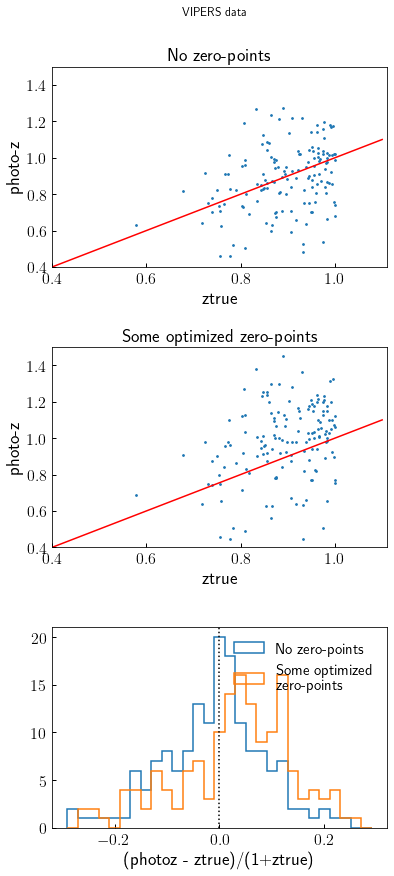

In [123]:
xdata = X_test_orig[sel].copy()

zb_0 = prediction_zp(xdata, 0.*xchain2[P2.argmin()])
zb_zp = prediction_zp(xdata, xchain2[P2.argmin()])


fig,ax = plt.subplots(3,1, figsize=(6,14), sharex=False, sharey=False)
ax[0].scatter(y_test[sel], zb_0, s=3)
ax[0].plot([0.4,1.1],[0.4,1.1], color='r')
ax[0].set_xlim(0.4,1.11)
ax[0].set_ylim(0.4,1.5)
ax[0].set_xlabel('ztrue')
ax[0].set_ylabel('photo-z')
ax[0].set_title('No zero-points')

ax[1].scatter(y_test[sel], zb_zp, s=3)
ax[1].plot([0.4,1.1],[0.4,1.1], color='r')
ax[1].set_xlim(0.4,1.11)
ax[1].set_ylim(0.4,1.5)
ax[1].set_xlabel('ztrue')
ax[1].set_ylabel('photo-z')
ax[1].set_title('Some optimized zero-points')

dz_bins = 0.02
bins = np.arange(-0.3+dz_bins/2., 0.3, dz_bins)
ax[2].hist((zb_0-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='No zero-points')
ax[2].hist((zb_zp-y_test[sel])/(1+y_test[sel]), bins=bins, histtype='step', lw=1.5,
          label='Some optimized \nzero-points')
ax[2].axvline(0,ls=':',color='k')
ax[2].set_xlabel('(photoz - ztrue)/(1+ztrue)')
ax[2].legend()

fig.suptitle('VIPERS data', y=0.94)
fig.subplots_adjust(hspace=0.4)
#plt.savefig('zeropoint_sdss_test1.png',bbox_inches='tight',dpi=300)
plt.show()

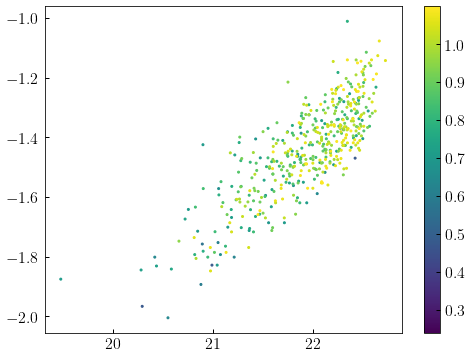

In [121]:
plt.figure(figsize=(8,6))
plt.scatter(X_test_orig[sel,-1], np.log10(X_err[sel,2]), s=4, c=y_test[sel]
           )
plt.colorbar()
plt.show()

In [30]:
sel = (label_test==0)&(y_test>0.1)&(y_test<0.2)&(X_test_orig[:,4]<17)

pzs = []
for i in range(10):
    #pzs.append(realization_pz(X_test_orig, X_test_orig_errors))
    pzs.append(realization_pz(X_test_orig[sel].copy(), 
    errors))
    
    print(i)
    
pz_final = np.sum(pzs,axis=0)
pz_final /= np.sum(pz_final,axis=1)[:,None]

NameError: name 'realization_pz' is not defined

In [27]:
truez, y_test[sel][0]

(0.10115006, 0.10115006)

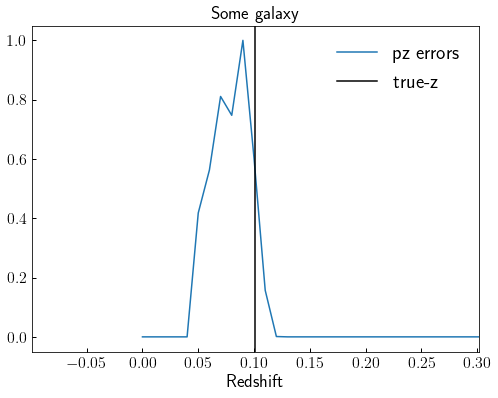

In [24]:
ig = 0

#photoz_orig = preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[sel,0][ig]
truez = y_test[sel][ig]

dz = 0.2

plt.figure(figsize=(8,6))
plt.plot(zgrid, pz_final[ig]/pz_final[ig].max(), '-', label='pz errors')
#plt.plot(zgrid, pz[sel][ig]/pz[sel][ig].max(), '--', label='pz from input' )
plt.axvline(truez, color='k',ls='-', label='true-z')
#plt.axvline(photoz_orig, color='k',ls='--', label='photo-z')
plt.xlim(truez-dz, truez+dz)
plt.xlabel('Redshift')
plt.title('Some galaxy')
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.savefig('dummy_test_2.png',bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
    photoz = np.zeros((Nintegral,2,len(f)))
    for i in range(Nintegral):
        f_real = np.random.normal(f, fe)
        
        f_real = preproc.transform(f_real)
        y_pred = np.array(model_train(f_real))
        
    
        weight = y_pred[2]
        weight = np.where(weight<1e-2, 0, weight)
        mu = y_pred[0]
        sig = np.sqrt(np.log(y_pred[1]))

        mu = preproc_y.inverse_transform(mu)
        sig = preproc_y.inverse_transform(sig)
        sig = np.clip(sig,0.001, np.inf)

        zipped = zip(mu.T, 
                 sig.T, 
                 weight.T)
        
        y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
        y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]

        photoz = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0]
        
        breakpoint()

In [38]:
zgrid = np.vstack([ztrue,photoz])
        pz = np.sum([gaussian_vect(zgrid, m,s,w) for (m,s,w) in zipped], axis=0)

1412.7993